In [43]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [44]:
# import the dataset 
# load in the Excel file and turn into dataframme 
file_path = "Shloshim.xlsx"
df = pd.read_excel(file_path, sheet_name=0)

# rename the columns for easier access
df.rename(columns={
    'Date': 'Date',
    'NVDA UW Equity - Last Price': 'NVDA',
    'AMD UW Equity - Last Price': 'AMD'
}, inplace=True)

# convert the date column to datetime for time series analysis 
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)  

In [45]:
# cleaning the dataset 

# # first we check for the missing values 
# # Check for missing values in each column
# missing_values = df.isnull().sum()
# missing_values

# # since there is only one missing row, then interpolate
# df.interpolate(method='linear', inplace=True)

# # confirming that missing values are handled
# missing_2 = df.isnull().sum()
# missing_2

num_cols = ["NVDA", "AMD"] # add more if needed
df[num_cols] = df[num_cols].interpolate() # linear is default
df.dropna(subset=num_cols, inplace=True) # prune any residual NaNs   

# create a rebased series
df["NVDA_rebased"] = df["NVDA"] / df["NVDA"].iloc[0]
df["AMD_rebased"]  = df["AMD"]  / df["AMD"].iloc[0]

# look at the result
display(df.head())

,NVDA,AMD,NVDA_rebased,AMD_rebased
Date,,,,
2025-03-13,115.58,98.11,1.000000,1.000000
2025-03-12,115.74,100.79,1.001384,1.027316
2025-03-11,108.76,96.76,0.940993,0.986240
2025-03-10,106.98,96.63,0.925593,0.984915
2025-03-07,112.69,100.31,0.974996,1.022424


In [46]:
# # normalise prices to compare relative change in values 
# # min-max normalisation based on first row
# df['NVDA_norm'] = df['NVDA'] / df['NVDA'].iloc[0]
# df['AMD_norm'] = df['AMD'] / df['AMD'].iloc[0]

# # Kalman Filter for pairs trading assumes the spread is stationary 
# # calculate the spread then apply the ADF test.
# from statsmodels.tsa.stattools import adfuller

# spread = df['NVDA_norm'] - df['AMD_norm']  

# adf_result = adfuller(spread)
# print("ADF Statistic:", adf_result[0])
# print("p-value:", adf_result[1])

In [47]:
# # the p value for the last normalisation was > 0.05 so we reject null hypothesis 
# # we try log prices instead of normal ones 
# df['log_NVDA'] = np.log(df['NVDA'])
# df['log_AMD'] = np.log(df['AMD'])
# spread2 = df['log_NVDA'] - df['log_AMD']

# adf_result2 = adfuller(spread2)
# print("ADF Statistic:", adf_result2[0])
# print("p-value:", adf_result2[1])

# # p values < 0.05 so we accept null hypothesis 

In [49]:
# computing the intitial hedge ratio
# this ratio tells us how many of AMD we need to buy to hedge NVDA 
df = df.sort_index(ascending=True)
df = df.iloc[5:].copy()
df["beta_dyn"] = beta_dyn

# define the two price series
X = df['AMD']
Y = df['NVDA']
# adding constant to X for the intercept term
# the intercept helps capture any fixed offset not explained by the slope 
X_const = sm.add_constant(X)

# fit the Ordinary Least Square model (linear regression)
# minimizes the sum of squared errros 
ols_model = sm.OLS(Y, X_const).fit()

alpha, beta = ols_model.params # α = intercept, β = hedge ratio
print(f"Intercept α  : {alpha: .6f}")
print(f"Hedge ratio β: {beta: .6f}")

# Compute static spread using BOTH α and β
df["spread_static"] = Y - (alpha + beta * X)

# Optional: quick stationarity check
adf_stat, p_val, *_ = adfuller(df["spread_static"].dropna())
print(f"ADF stat = {adf_stat: .3f},  p‑value = {p_val: .4f}")

# can also add a plot for this 

Intercept α  : -49.958251
Hedge ratio β:  0.877249
ADF stat = -0.457,  p‑value =  0.9002


In [50]:
# Run a 1‑state Kalman filter for βₜ 
def kalman_beta(y, x, q= 0.0001, r= 1.0, beta0=0.0, P0=1.0):
    """Return series of time‑varying hedge ratios βₜ."""
    n = len(x)
    beta = np.empty(n)
    P = np.empty(n)

    beta[0], P[0] = beta0, P0

    for t in range(1, n):
        # Prediction
        P_pred = P[t-1] + q

        # Update
        K_t = P_pred * x[t] / (x[t]**2 * P_pred + r)
        beta[t] = beta[t-1] + K_t * (y[t] - beta[t-1] * x[t])
        P[t] = (1 - K_t * x[t]) * P_pred

    return beta

y = df["NVDA"].values
x = df["AMD"].values

beta_dyn = kalman_beta(y, x)

# 7 b.  Dynamic spread and stationarity check 
df["spread_dyn"] = df["NVDA"] - beta_dyn * df["AMD"]

adf_stat, p_val, *_ = adfuller(df["spread_dyn"])
print(f"ADF stat = {adf_stat:.3f},  p‑value = {p_val:.4f}")

# the ADF stat and the p value are almost too perfect. vary q and r to make sure there isnt overfitting 

ADF stat = -8.970,  p‑value = 0.0000


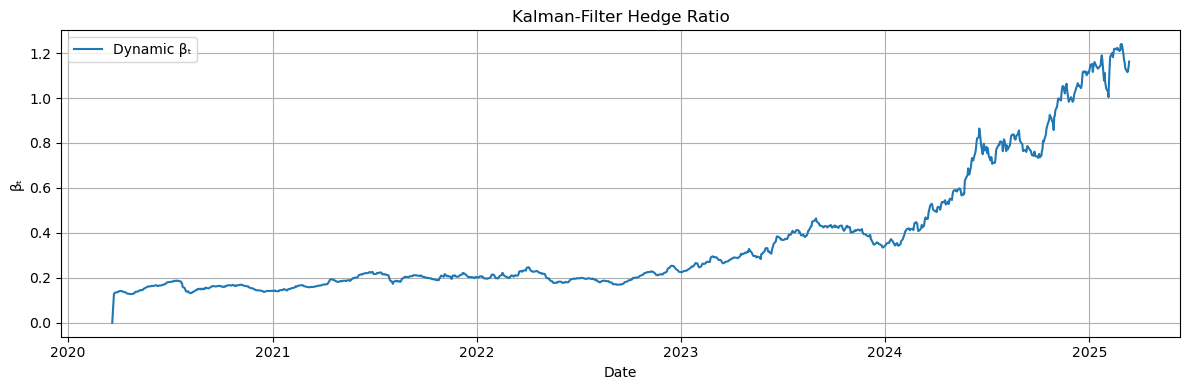

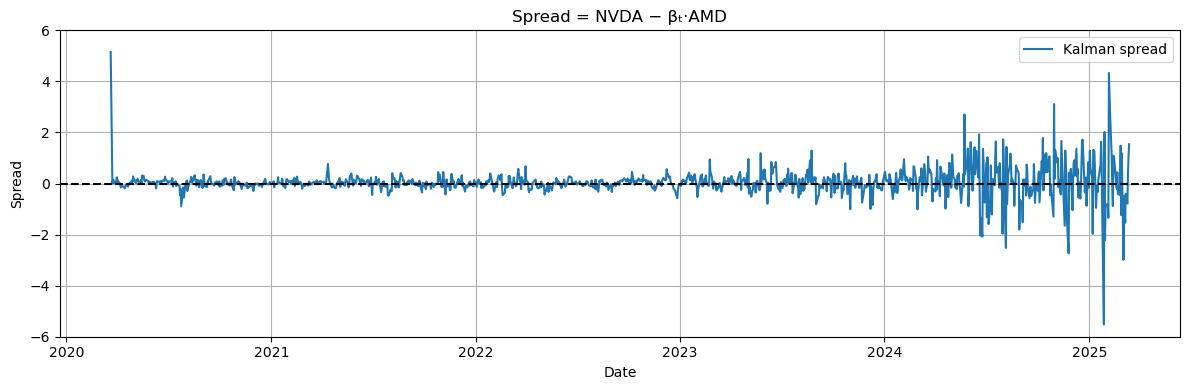

In [51]:
# 8 a. Hedge ratio
plt.figure(figsize=(12, 4))
plt.plot(df.index, beta_dyn, label="Dynamic βₜ")
plt.title("Kalman‑Filter Hedge Ratio")
plt.xlabel("Date");  plt.ylabel("βₜ")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# 8 b. Spread
plt.figure(figsize=(12, 4))
plt.plot(df.index, df["spread_dyn"], label="Kalman spread")
plt.ylim(-6,6)
plt.axhline(0, color="k", ls="--")
plt.title("Spread = NVDA − βₜ·AMD")
plt.xlabel("Date");  plt.ylabel("Spread")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


In [52]:
# 9 a. Z‑score 
mean_s = df["spread_dyn"].mean()
std_s  = df["spread_dyn"].std(ddof=0)
df["z"] = (df["spread_dyn"] - mean_s) / std_s

# 9 b. Raw entry/exit signals (time‑t decision) 
entry_z = 0.8   # enter at ±0.8σ instead of ±1σ
exit_z = 0.2   # exit at ±0.2σ instead of ±0.5σ

raw_sig[df["z"] < -entry_z] =  1   # long spread
raw_sig[df["z"] >  entry_z] = -1   # short spread
raw_sig[df["z"].abs() < exit_z] =  0   # exit band

# raw_sig = pd.Series(0, index=df.index, dtype=int)
# raw_sig[df["z"] < -1] = 1 # long spread  => long NVDA, short AMD
# raw_sig[df["z"] > 1] = -1 # short spread => short NVDA, long AMD
# raw_sig[df["z"].abs() < 0.5] = 0 # exit band

# 9 c. Lag one bar to avoid look‑ahead bias  
sig = raw_sig.shift(1).fillna(0).astype(int)

# 9 d. Position book with proper flattening 
pos = sig.replace(0, np.nan).ffill().fillna(0).astype(int)
df["position"] = pos

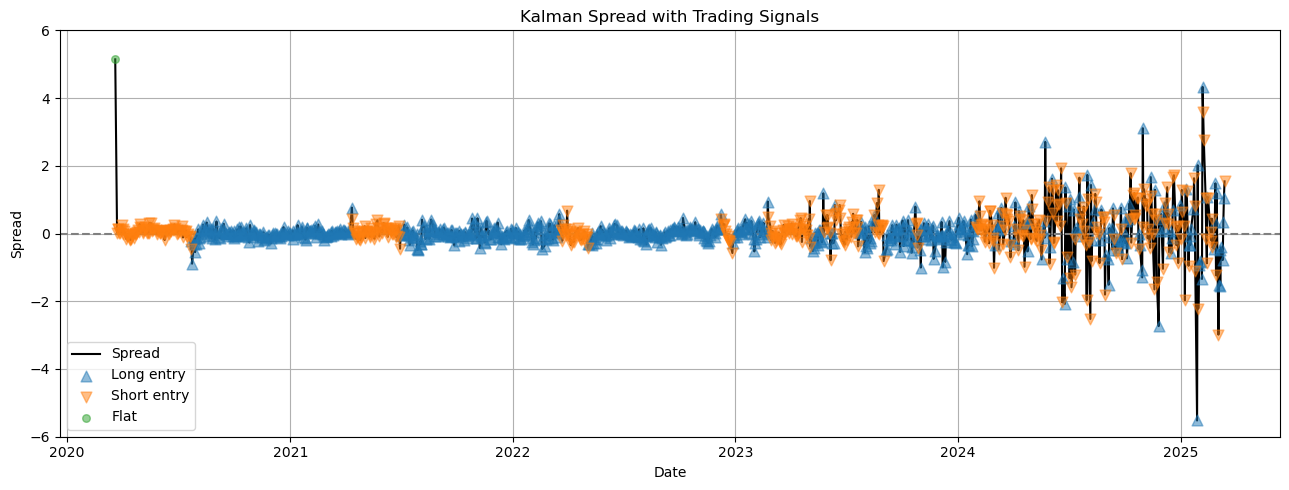

In [55]:
plt.figure(figsize=(13, 5))
plt.plot(df.index, df["spread_dyn"], color="black", label="Spread")
plt.ylim(-6,6)
plt.axhline(0, color="grey", ls="--")

plt.scatter(df.index[df["position"] ==  1],
            df["spread_dyn"][df["position"] ==  1],
            marker="^", s=60, alpha=0.5, label="Long entry", zorder=3)

plt.scatter(df.index[df["position"] == -1],
            df["spread_dyn"][df["position"] == -1],
            marker="v", s=60, alpha=0.5, label="Short entry", zorder=3)

plt.scatter(df.index[(df["position"] == 0) & (sig == 0)],
            df["spread_dyn"][(df["position"] == 0) & (sig == 0)],
            marker="o", s=30, alpha=0.5, label="Flat", zorder=3)

plt.title("Kalman Spread with Trading Signals")
plt.xlabel("Date");  plt.ylabel("Spread")
plt.grid();  plt.legend();  plt.tight_layout()
plt.show()


In [54]:
import numpy as np
import pandas as pd

# 1) PARAMETERS
capital_per_point = 10_000   # $ P&L per 1pt move in spread
trading_days     = 252

# 2) INTRADAY P&L: position(t-1) * Δspread
df["pnl"] = (
    df["position"].shift(1)    # use yesterday's position
    * df["spread_dyn"].diff()  # change in spread today
    * capital_per_point        # dollars per spread point
)
df["pnl"].fillna(0, inplace=True)

# 3) EQUITY CURVE
df["equity"] = df["pnl"].cumsum()

# 4) DAILY RETURNS (on equity)
initial_capital = 100_000
df["ret"] = df["pnl"] / initial_capital

# 5) PERFORMANCE METRICS
# Sharpe ratio (annualized)
sharpe = df["ret"].mean() / df["ret"].std(ddof=0) * np.sqrt(trading_days)

# Maximum drawdown
cum_max    = df["equity"].cummax()
drawdowns  = df["equity"] - cum_max
max_drawdown = drawdowns.min()

# 6) TRADE‑BY‑TRADE P&L FOR WIN/LOSS RATIO
# Find entry and exit indices
entries = df.index[(df["position"] != 0) & (df["position"].shift(1) == 0)]
exits   = df.index[(df["position"] == 0) & (df["position"].shift(1) != 0)]

# Align them (drop last open trade if any)
if len(exits) < len(entries):
    entries = entries[:len(exits)]
elif len(entries) < len(exits):
    exits = exits[:len(entries)]

trade_pnls = []
for entry, exit_ in zip(entries, exits):
    pnl_trade = df.at[exit_, "equity"] - df.at[entry, "equity"]
    trade_pnls.append(pnl_trade)

trade_pnls = np.array(trade_pnls)
win_trades = trade_pnls[trade_pnls > 0]
loss_trades= trade_pnls[trade_pnls < 0]

win_loss_ratio = (
    len(win_trades) / len(loss_trades)
    if len(loss_trades)>0 else np.nan
)

# 7) SUMMARY PRINT
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: ${max_drawdown:,.0f}")
print(f"Total P&L: ${df['equity'].iloc[-1]:,.0f}")
print(f"Number Trades: {len(trade_pnls)}")
print(f"Win/Loss Ratio: {win_loss_ratio:.2f}")
print(f"Avg Win / Avg Loss: "
      f"{win_trades.mean():.0f} / {loss_trades.mean():.0f}")


Sharpe Ratio     : 0.71
Max Drawdown     : $-107,865
Total P&L        : $370,158
Number Trades    : 1
Win/Loss Ratio   : nan
Avg Win / Avg Loss: nan / nan


/tmp/ipykernel_89/568930819.py:64: RuntimeWarning: Mean of empty slice.
  f"{win_trades.mean():.0f} / {loss_trades.mean():.0f}")
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
